<font style = bold size = 40 color=darkgreen>Dutch Rental Prices</font><br>
*Creating a regression model to predict the rent prices in the Netherlands using data from Fund.nl*<br>
**Steps:**<br>
1. Importing libraries and reading data
2. EDA and re-shaping data for ML pre-processing 
3. Feature engineering
4. Creating model

*Predicting the rent prices from Funda in the Netherlands*

# <font color=teal>Import data</font>

In [18]:
# Data manipulation
import pandas as pd
import numpy as np
import sidetable as stb

#ML libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Options for pandas
pd.options.display.max_columns
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input,Output

20

In [19]:
# Reading data from Funda.nl
#PC
#df = pd.read_json('/Users/michaelcondon/Desktop/Projects_files/Data_Science/properties.json', lines=True)

#Mac
df = pd.read_json("/Users/michaelcondon/Documents/GitHub/Amsterdam rentals/Netherlands-Rental-Prices/properties-trim.json",lines=True)

# <font color=teal>EDA and reshaping data</font>

> **<font color=brown>Overview</font>**
> 1. Dropping non-needed columns
> 2. Missing values
> 3. All continuous values
> 4. Distribution of continuous values
> 5. Categorical values
> 6. Cardinality of categorical values
> 7. Outliers
> 8. Relationship between indeendant and dependant variables

In [13]:
# Creating copy of main df
data = df

In [14]:
# Viewing first 2 lines of the dataframe
data.head(2)

_id      externalId areaRaw  areaSqm  \
0  {'$oid': '5d2b113a43cbfd7c77a998f4'}    room-1686123   14 m2       14   
1  {'$oid': '5d2b113a43cbfd7c77a9991a'}  studio-1691193   30 m2       30   

        city                                      coverImageUrl crawlStatus  \
0  Rotterdam  https://resources.kamernet.nl/image/913b4b03-5...        done   
1  Amsterdam  https://resources.kamernet.nl/image/5e11d6b5-8...        done   

                                   crawledAt  \
0  {'$date': '2019-07-26T22:18:23.018+0000'}   
1  {'$date': '2019-08-10T22:28:46.099+0000'}   

                                      datesPublished  \
0  [{'$date': '2019-07-14T11:25:46.511+0000'}, {'...   
1  [{'$date': '2019-07-14T11:25:46.677+0000'}, {'...   

                                 firstSeenAt  ...  \
0  {'$date': '2019-07-14T11:25:46.511+0000'}  ...   
1  {'$date': '2019-07-14T11:25:46.677+0000'}  ...   

                                 registrationCostRaw roommates  shower  \
0  \n                            € 0\n           ...         5  Shared   
1  \n                            € 0\n           ...      None     Own   

   smokingInside  toilet userDisplayName     userId userLastLoggedOn  \
0             No  Shared      Huize west  4680711.0       21-07-2019   
1             No     Own             Cor  1865530.0       20-07-2019   

   userMemberSince                                       userPhotoUrl  
0       26-06-2019  https://resources.kamernet.nl/Content/images/s...  
1       05-01-2012  https://resources.kamernet.nl/Content/images/p...  

[2 rows x 61 columns]

In [15]:
# Reviewing details of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12830 entries, 0 to 12829
Data columns (total 61 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   _id                          12830 non-null  object 
 1   externalId                   12830 non-null  object 
 2   areaRaw                      12830 non-null  object 
 3   areaSqm                      12830 non-null  int64  
 4   city                         12830 non-null  object 
 5   coverImageUrl                12830 non-null  object 
 6   crawlStatus                  12830 non-null  object 
 7   crawledAt                    12830 non-null  object 
 8   datesPublished               12830 non-null  object 
 9   firstSeenAt                  12830 non-null  object 
 10  furnish                      12830 non-null  object 
 11  lastSeenAt                   12830 non-null  object 
 12  latitude                     12830 non-null  float64
 13  longitude       

***Identified some columns with significant nulls that need to be addressed***

> ## <font color=brown>Dropping columns with +50% nulls</font>

In [16]:
data = data.drop(['deposit', 'additionalCostsRaw', 'additionalCosts', 'registrationCost'], axis=1)

> **<font color=brown>Dropping unneeded columns</font>**

In [21]:
data = data.drop(['_id','coverImageUrl','crawlStatus', 'crawledAt', 'datesPublished', 'url', 'source',
              'descriptionNonTranslated','descriptionNonTranslatedRaw','descriptionTranslated',
              'descriptionTranslatedRaw', 'detailsCrawledAt', 'pageDescription', 'pageTitle','userDisplayName',
              'userId','userLastLoggedOn','userMemberSince','userPhotoUrl', 'areaRaw','rentRaw','registrationCostRaw','depositRaw'], axis=1)

In [22]:
cols = list(data.columns)

> ## <font color=brown>Continuous columns and fixing nulls<font>

In [23]:
#creating a list of columns that have continuous values
continuous = []

for col in cols:
    if data[col].dtype != "O":
        continuous.append(col)


In [26]:
continuous

['areaSqm']

In [25]:
#lat and long are location type and rent is our target, so only need 'areaSqm'

del continuous[1:4]

In [27]:
# checking for nulls in continuous columns (areaSqm)
for col in continuous:
    na = sum(data[col].isna())
    print ("The number of nulls in {} is {}".format(col,na))

The number of nulls in areaSqm is 0


In [14]:
# analyzing the data in continuous (areaSqm)
data.areaSqm.describe()

count    46722.000000
mean        31.616626
std         29.863150
min          6.000000
25%         14.000000
50%         20.000000
75%         40.000000
max        675.000000
Name: areaSqm, dtype: float64

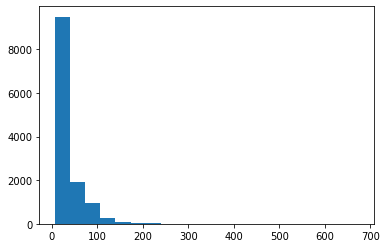

areaSqm is non-normally distributed


In [28]:
# analyzing distribution of values in continuous (areaSqm)
_=plt.hist(data.areaSqm, bins = 20)
plt.show()
print("areaSqm is non-normally distributed")

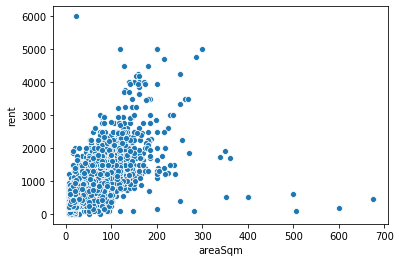

In [29]:
# analyzing relationship between areaSqm and rental price
_ = sns.scatterplot(x=data.areaSqm,y=data.rent)

***Seems to be some relationship between areaSqm and our target of rent***

In [30]:
#use logarithmic trasnformation as data for areaSqm is not normally distributed

data['areaSqm_log'] = np.log(data.areaSqm)
data['rent_log'] = np.log(data.rent)

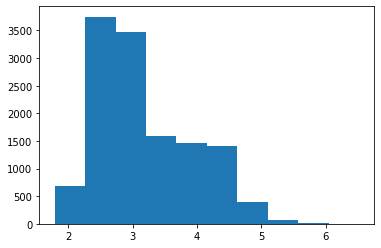

areaSqm is now better distributed


In [33]:
_=plt.hist(data.areaSqm_log)
plt.show()
print("areaSqm is now better distributed")

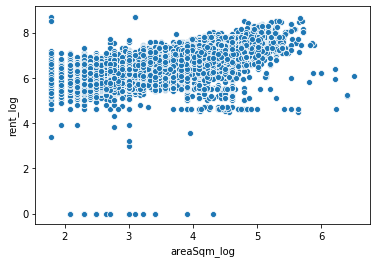

In [20]:
_ = sns.scatterplot(x=data.areaSqm_log,y=data.rent_log)

outliers exist in areaAqm


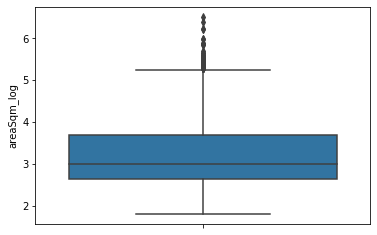

In [32]:
# checking for outliers in areaSqm

_=sns.boxplot(data.areaSqm_log, orient="vertical")
print("outliers exist in areaAqm")

> ## <font color = brown>Categorical columns fixing nulls</font>

In [34]:
# creating a list of columns with a data type of object

categorical = []

for col in cols:
    if data[col].dtype == "O":
        categorical.append(col)

In [35]:
data[categorical].head(1)

externalId       city                                firstSeenAt  \
0  room-1686123  Rotterdam  {'$date': '2019-07-14T11:25:46.511+0000'}   

       furnish                                 lastSeenAt postalCode  \
0  Unfurnished  {'$date': '2019-07-26T22:18:23.142+0000'}     3074HN   

  postedAgo propertyType                rawAvailability rentDetail  ...  \
0        4w         Room  26-06-'19 - Indefinite period             ...   

     matchGender matchGenderBackup matchLanguages    matchStatus  \
0  Not important     Not important  Not important  Not important   

  matchStatusBackup pets roommates  shower smokingInside  toilet  
0     Not important   No         5  Shared            No  Shared  

[1 rows x 30 columns]

In [36]:
#columns not needed for categorical list

categorical.remove("externalId") #doesn't meet criteria
categorical.remove("firstSeenAt") #time data
categorical.remove("lastSeenAt") #time data
categorical.remove("postedAgo") #time data
categorical.remove("rawAvailability") #time data, mixed data
categorical.remove("matchStatusBackup") #redundant
categorical.remove("matchGenderBackup") #redundant


In [37]:
print("There are {} columns that are categorical".format(len(categorical)))

There are 23 columns that are categorical


In [38]:
# checking for nulls in categorical columns and creating a list

cats_to_fix = []
for col in categorical:
    na = sum(data[col].isna())
    if na > 0:
        cats_to_fix.append(col)
    print ("The number of nulls in {} is {}".format(col,na))
print(cats_to_fix)
print("There are {} columns with null values that need to be addressed".format(len(cats_to_fix)))

The number of nulls in city is 0
The number of nulls in furnish is 0
The number of nulls in postalCode is 0
The number of nulls in propertyType is 0
The number of nulls in rentDetail is 0
The number of nulls in title is 0
The number of nulls in energyLabel is 81
The number of nulls in gender is 81
The number of nulls in internet is 81
The number of nulls in isRoomActive is 81
The number of nulls in kitchen is 81
The number of nulls in living is 81
The number of nulls in matchAge is 81
The number of nulls in matchAgeBackup is 81
The number of nulls in matchCapacity is 81
The number of nulls in matchGender is 81
The number of nulls in matchLanguages is 81
The number of nulls in matchStatus is 81
The number of nulls in pets is 81
The number of nulls in roommates is 81
The number of nulls in shower is 81
The number of nulls in smokingInside is 81
The number of nulls in toilet is 81
['energyLabel', 'gender', 'internet', 'isRoomActive', 'kitchen', 'living', 'matchAge', 'matchAgeBackup', 'mat

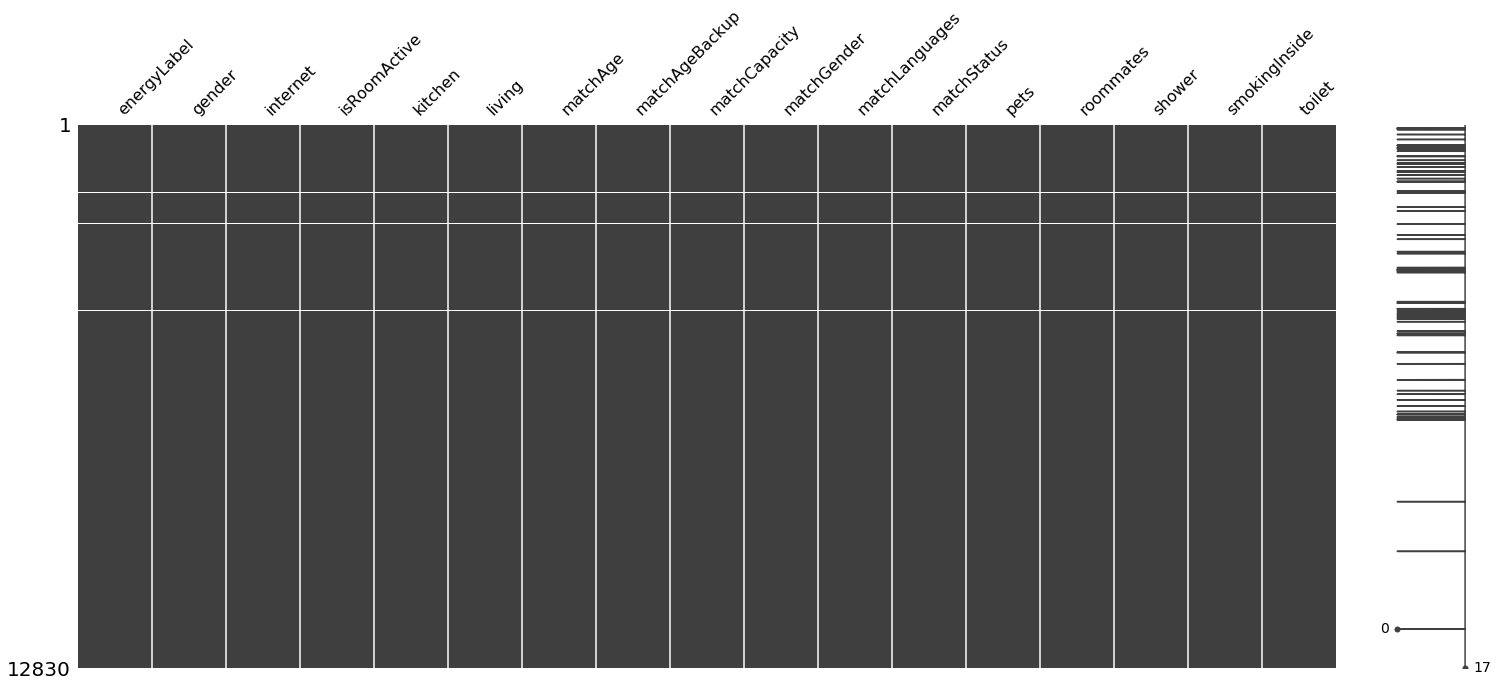

In [40]:
# visualizing 
_=msno.matrix(data[cats_to_fix])

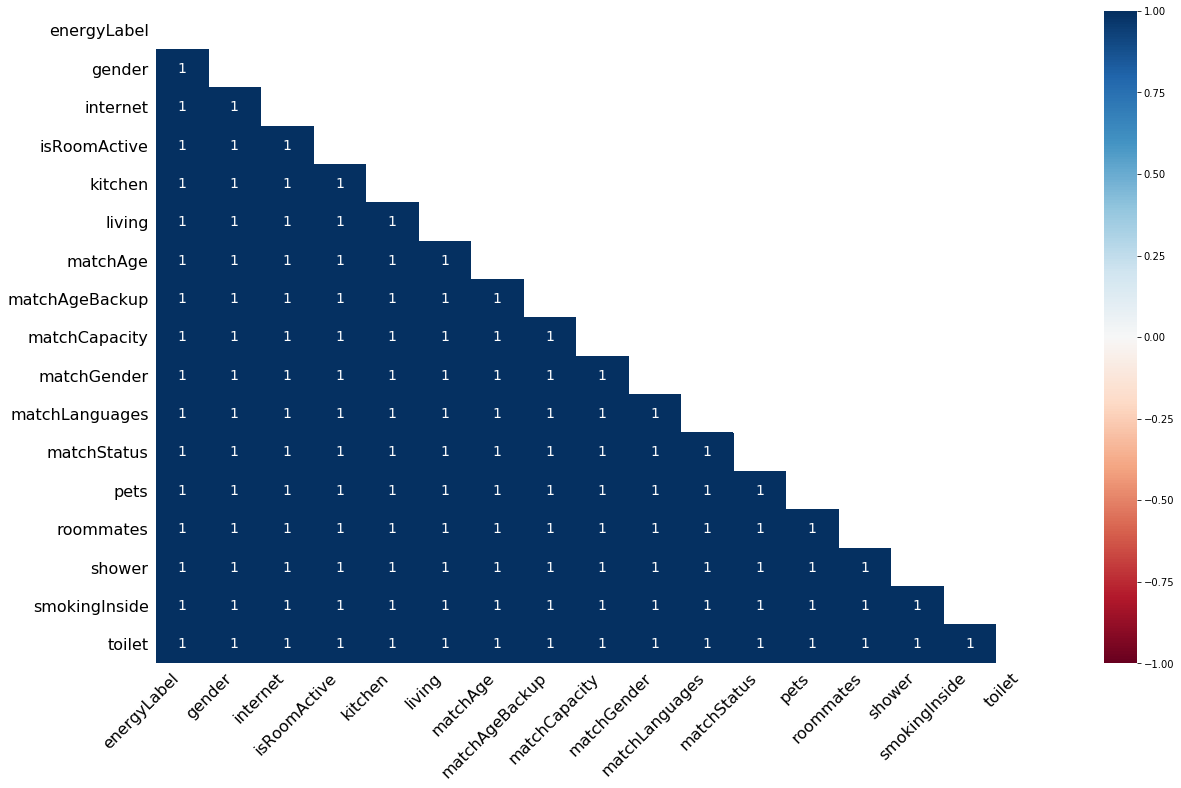

In [42]:
# heat map of nulls
_=msno.heatmap(data[cats_to_fix])

***Equal number of nulls and visualization indicates whole rows with null values***

In [45]:

data[cats_to_fix].isna().sum(axis=1).sort_values(ascending=False).value_counts()

0    12749
dtype: int64

In [44]:
#Dropping rows with more than 2 missing values

rows_to_drop = list(data.index[data[cats_to_fix].isna().sum(axis=1)>2])
data = data.drop(rows_to_drop, axis=0)
data.shape

(12749, 36)

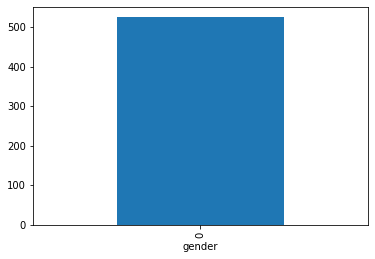

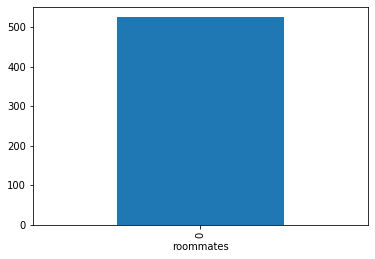

In [46]:
# 'gender'and 'roomates' have binary data
for col in data[['gender','roommates']]:
    temp_df = data
    
    #creating a variable that inidcates 1 if null or 0 if not
    temp_df[col] = np.where(temp_df[col].isna(),1,0)
    
    _ = temp_df.groupby(col)['rent'].median().plot.bar()
    plt.show()

In [47]:
# checking for blanks/missing values in categorical columns
for col in categorical:
    print('There are {} missing values in {}'.format(sum(data[col] == ""),col))

There are 0 missing values in city
There are 217 missing values in furnish
There are 0 missing values in postalCode
There are 0 missing values in propertyType
There are 3788 missing values in rentDetail
There are 0 missing values in title
There are 0 missing values in energyLabel
There are 0 missing values in gender
There are 0 missing values in internet
There are 0 missing values in isRoomActive
There are 0 missing values in kitchen
There are 0 missing values in living
There are 0 missing values in matchAge
There are 0 missing values in matchAgeBackup
There are 0 missing values in matchCapacity
There are 0 missing values in matchGender
There are 0 missing values in matchLanguages
There are 0 missing values in matchStatus
There are 0 missing values in pets
There are 0 missing values in roommates
There are 0 missing values in shower
There are 0 missing values in smokingInside
There are 0 missing values in toilet


/Users/michaelcondon/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [49]:
# 'furnish' and 'rentalDetail' have a lot of missing values
# replacing missing values with nan 
data[['furnish', 'rentDetail']] = data[['furnish', 'rentDetail']].replace(r'^\s*$', np.nan, regex=True)

In [50]:
# replacing nans with 'Missing'
data[categorical] = data[categorical].fillna('Missing')

In [51]:
for col in categorical:
    print('There are {} missing values in {}'.format(sum(data[col].isna()),col))
    

There are 0 missing values in city
There are 0 missing values in furnish
There are 0 missing values in postalCode
There are 0 missing values in propertyType
There are 0 missing values in rentDetail
There are 0 missing values in title
There are 0 missing values in energyLabel
There are 0 missing values in gender
There are 0 missing values in internet
There are 0 missing values in isRoomActive
There are 0 missing values in kitchen
There are 0 missing values in living
There are 0 missing values in matchAge
There are 0 missing values in matchAgeBackup
There are 0 missing values in matchCapacity
There are 0 missing values in matchGender
There are 0 missing values in matchLanguages
There are 0 missing values in matchStatus
There are 0 missing values in pets
There are 0 missing values in roommates
There are 0 missing values in shower
There are 0 missing values in smokingInside
There are 0 missing values in toilet


Text(0.5, 0, 'furnish')

Text(0, 0.5, 'rent')

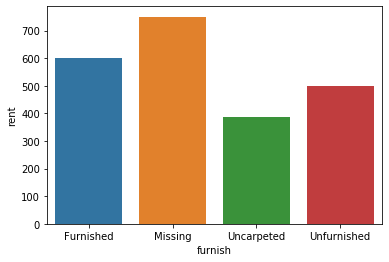

Text(0.5, 0, 'propertyType')

Text(0, 0.5, 'rent')

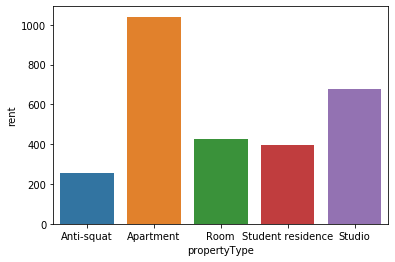

Text(0.5, 0, 'rentDetail')

Text(0, 0.5, 'rent')

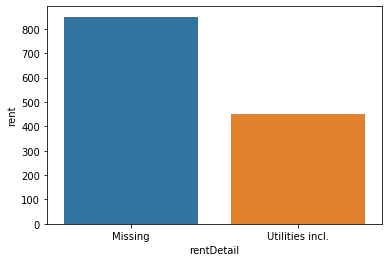

Text(0.5, 0, 'energyLabel')

Text(0, 0.5, 'rent')

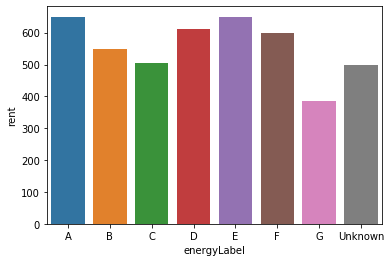

Text(0.5, 0, 'gender')

Text(0, 0.5, 'rent')

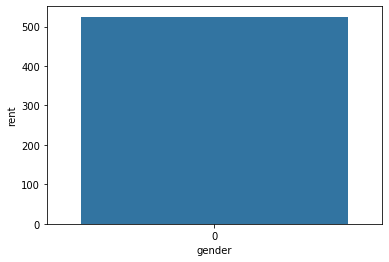

Text(0.5, 0, 'internet')

Text(0, 0.5, 'rent')

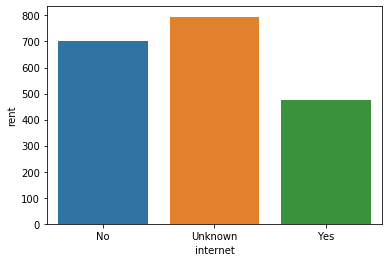

Text(0.5, 0, 'isRoomActive')

Text(0, 0.5, 'rent')

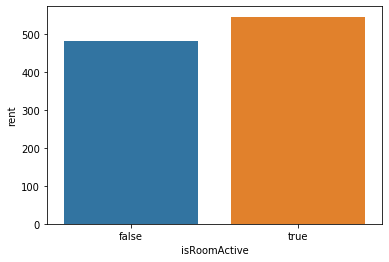

Text(0.5, 0, 'kitchen')

Text(0, 0.5, 'rent')

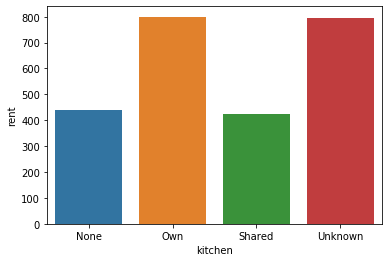

Text(0.5, 0, 'living')

Text(0, 0.5, 'rent')

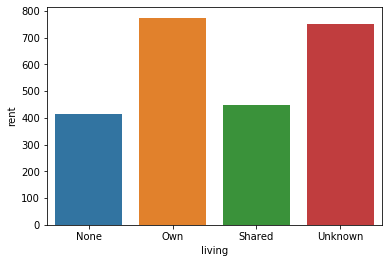

Text(0.5, 0, 'matchCapacity')

Text(0, 0.5, 'rent')

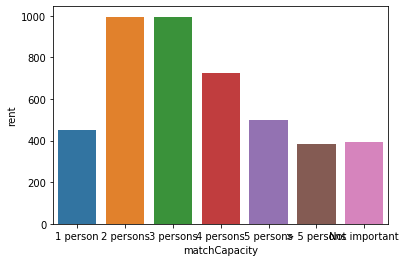

Text(0.5, 0, 'matchGender')

Text(0, 0.5, 'rent')

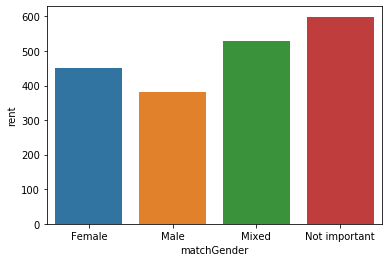

Text(0.5, 0, 'pets')

Text(0, 0.5, 'rent')

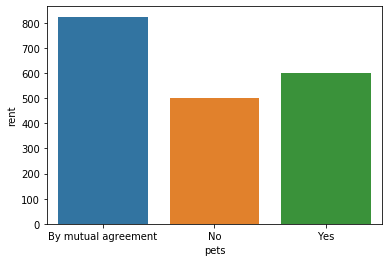

Text(0.5, 0, 'roommates')

Text(0, 0.5, 'rent')

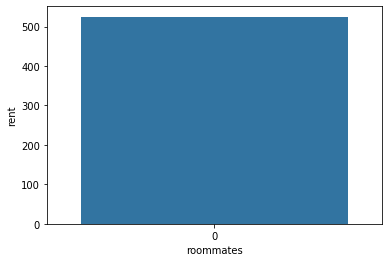

Text(0.5, 0, 'shower')

Text(0, 0.5, 'rent')

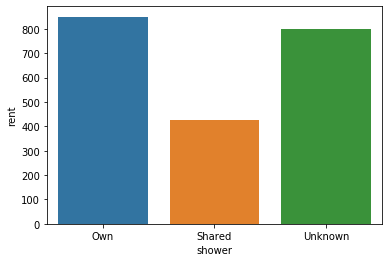

Text(0.5, 0, 'smokingInside')

Text(0, 0.5, 'rent')

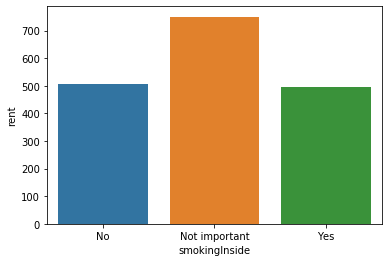

Text(0.5, 0, 'toilet')

Text(0, 0.5, 'rent')

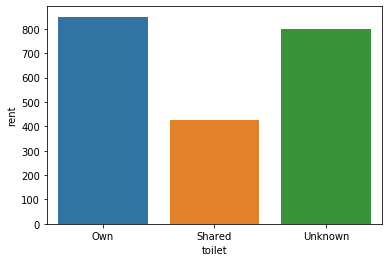

In [52]:
# viszualizing categorical values with less than 10 unique values
for col in categorical:
    if len(data.groupby(col)['rent'].median().reset_index()[col]) < 10:
        _=sns.barplot(x = data.groupby(col)['rent'].median().reset_index()[col],y = data.groupby(col)['rent'].median().reset_index()['rent'])
        plt.xlabel(col)
        plt.ylabel('rent')
        plt.show()

> **<font color=brown>Time and date data</font>**<br>
Date columns need to be adjusted to get proper date formating 

In [54]:
# adding a copy of the columns to work on 
data['first_seen_date'] = data.firstSeenAt.apply(pd.Series)
data['last_seen_date'] = data.lastSeenAt.apply(pd.Series)

In [55]:
# dropping original columns
data = data.drop(['firstSeenAt','lastSeenAt'], axis=1)

In [56]:
# creating dataframe with just date columns
temporal = ["first_seen_date","last_seen_date"]

In [57]:
# stripping away text and converting dates to datetime64
for col in temporal:
    data[col] = data[col].astype(str).str[:10].astype(np.datetime64)

In [58]:
data[temporal].head(2)

first_seen_date last_seen_date
0      2019-07-14     2019-07-26
1      2019-07-14     2019-08-10

In [59]:
# getting the duration of each post in days
data['post_duration'] = (data.last_seen_date - data.first_seen_date).astype('str').str.split(" ", expand=True)[0].astype('int')

In [60]:
# checking the posts with 0 duration days 
len(data[data.post_duration == 0])

744

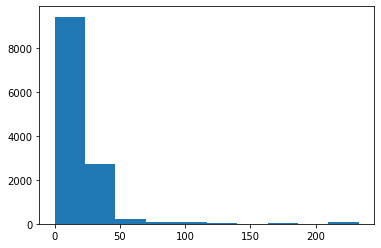

In [62]:
# visualization of duration data distribution
_=plt.hist(data.post_duration)

In [63]:
# creating a list of date columns
temporal = ["first_seen_date","last_seen_date", 'post_duration']

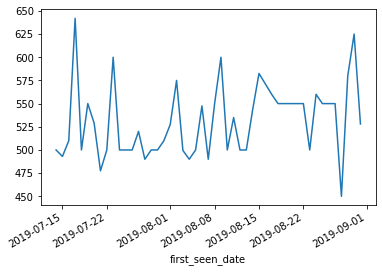

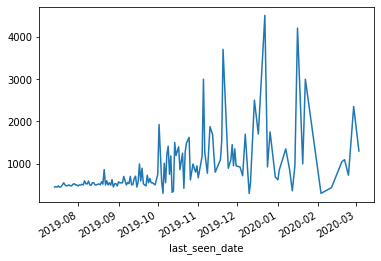

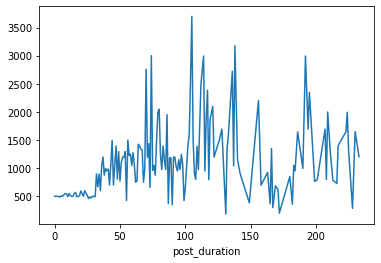

In [64]:
# visualizing date columns and relationship with rent
for col in temporal:
    _ = data.groupby(col)['rent'].median().plot()
    plt.show()

(737254.0, 737303.0)

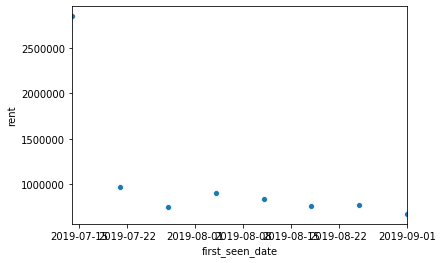

(737254.0, 737492.0)

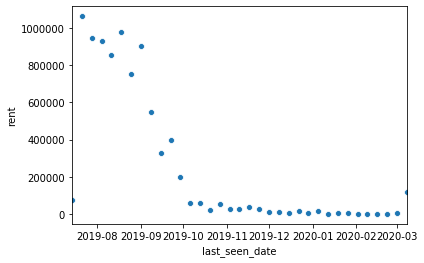

In [65]:
# visualizing date columns and relationship with rent
for col in temporal[0:2]:
    temp = data.set_index(col, drop=True)
    temp = temp.resample('W')['rent'].sum().reset_index()
    _ = sns.scatterplot(x = temp[col], y=temp.rent)
    plt.xlim(min(temp[col]), max(temp[col]))
    plt.show()

# <font color=teal>Feature Engineering</font>

> ## <font color=brown>Organizing data for ML modeling<font>

In [66]:
#creating dataframe with only the selected and cleaned categorical columns and normalized continuous columns
data_ml = data.drop(['areaSqm','rent','latitude', 'longitude', 'postedAgo','matchGender', 'matchGenderBackup', 'matchCapacity', 'matchStatus', 'matchAgeBackup','matchAge', 'matchLanguages', 'matchStatusBackup', 'gender', 'rawAvailability', 'first_seen_date', 'last_seen_date', 'post_duration'], axis=1 )

In [67]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12749 entries, 0 to 12829
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   externalId     12749 non-null  object 
 1   city           12749 non-null  object 
 2   furnish        12749 non-null  object 
 3   postalCode     12749 non-null  object 
 4   propertyType   12749 non-null  object 
 5   rentDetail     12749 non-null  object 
 6   title          12749 non-null  object 
 7   energyLabel    12749 non-null  object 
 8   internet       12749 non-null  object 
 9   isRoomActive   12749 non-null  object 
 10  kitchen        12749 non-null  object 
 11  living         12749 non-null  object 
 12  pets           12749 non-null  object 
 13  roommates      12749 non-null  int64  
 14  shower         12749 non-null  object 
 15  smokingInside  12749 non-null  object 
 16  toilet         12749 non-null  object 
 17  areaSqm_log    12749 non-null  float64
 18  rent_l

In [68]:
# creating lists from our ML dataframe based on type
ml_cat = []
ml_cont = []
ml_temp = []

for col in list(data_ml.columns):
    if data_ml[col].dtype == 'object':
        ml_cat.append(col)
    elif data_ml[col].dtype == 'datetime64[ns]':
        ml_temp.append(col)
    else:
        ml_cont.append(col)

ml_cat.append('roommates')
ml_cont.remove('roommates')
ml_cat.remove('externalId')

print('these are the ml_cat features {}'.format(ml_cat))
print('these are the ml_cont features {}'.format(ml_cont))
print('these are the ml_temp features {}'.format(ml_temp))



these are the ml_cat features ['city', 'furnish', 'postalCode', 'propertyType', 'rentDetail', 'title', 'energyLabel', 'internet', 'isRoomActive', 'kitchen', 'living', 'pets', 'shower', 'smokingInside', 'toilet', 'roommates']
these are the ml_cont features ['areaSqm_log', 'rent_log']
these are the ml_temp features []


Code for checking for rare values<br>
Could remove categorical values that represent less than 1% of observations<br>
Decided to skip after running the model<br><br>
for feature in ml_cat:
    temp = data_ml.groupby(feature)['rent_log'].count()/len(data_ml)
    temp_df = temp[temp>0.01].index
    data_ml[feature] = np.where(data_ml[feature].isin(temp_df),data_ml[feature],'Rare_var')

In [69]:
data_ml.head()

externalId       city      furnish postalCode propertyType  \
0    room-1686123  Rotterdam  Unfurnished     3074HN         Room   
1  studio-1691193  Amsterdam    Furnished     1018AS       Studio   
2    room-1690545  Amsterdam    Furnished     1075SB         Room   
3    room-1680036      Assen  Unfurnished     9407BG         Room   
4    room-1691356  Rotterdam  Unfurnished     3035AK         Room   

        rentDetail                 title energyLabel internet isRoomActive  \
0          Missing  West-Varkenoordseweg     Unknown      Yes         true   
1  Utilities incl.           Parelstraat     Unknown      Yes         true   
2  Utilities incl.            Zeilstraat     Unknown      Yes         true   
3  Utilities incl.           Ruiterakker     Unknown      Yes        false   
4  Utilities incl.       Zwart Janstraat     Unknown  Unknown         true   

  kitchen  living pets  roommates  shower smokingInside  toilet  areaSqm_log  \
0  Shared    None   No          0  Shared            No  Shared     2.639057   
1     Own     Own   No          0     Own            No     Own     3.401197   
2  Shared  Shared  Yes          0  Shared           Yes  Shared     2.397895   
3  Shared    None   No          0  Shared           Yes  Shared     2.772589   
4     Own     Own   No          0  Shared            No  Shared     3.091042   

   rent_log  
0  6.214608  
1  6.856462  
2  6.907755  
3  5.669881  
4  6.163315

> ## <font color=brown>Converting categorical features to numbers</font>

In [73]:
# looping through ml dataframe to replace string values with ordered numeric values

# list of all categorical feature columns
for feature in ml_cat: 
    
    # sorting unqiue values for each feature by average rent to get an ordered list 
    labels_ordered = data_ml.groupby([feature])['rent_log'].mean().sort_values().index
    
    # creating a dictionary with each unique value as a key and the rank as a value
    labels_ordered = {k:i for i, k in enumerate(labels_ordered,0)}
    
    # mapping the dictionary to the columns in the dataframe to replace the values with the dictionary values
    data_ml[feature] = data_ml[feature].map(labels_ordered)

In [75]:
data_ml.describe()

city       furnish    postalCode  propertyType    rentDetail  \
count  12749.000000  12749.000000  12749.000000  12749.000000  12749.000000   
mean     250.879677      1.333987   3937.285199      2.587968      0.297121   
std       97.909508      0.731528   2287.761356      0.897675      0.457008   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      194.000000      1.000000   1918.000000      2.000000      0.000000   
50%      260.000000      1.000000   3959.000000      2.000000      0.000000   
75%      326.000000      2.000000   5833.000000      4.000000      1.000000   
max      475.000000      3.000000   8069.000000      4.000000      1.000000   

              title   energyLabel      internet  isRoomActive       kitchen  \
count  12749.000000  12749.000000  12749.000000  12749.000000  12749.000000   
mean    2564.483018      1.363401      0.497843      0.813554      1.056083   
std     1423.311298      1.092568      0.834200      0.389481      1.263549   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     1375.000000      1.000000      0.000000      1.000000      0.000000   
50%     2588.000000      1.000000      0.000000      1.000000      0.000000   
75%     3714.000000      1.000000      1.000000      1.000000      2.000000   
max     5260.000000      7.000000      2.000000      1.000000      3.000000   

             living          pets  roommates        shower  smokingInside  \
count  12749.000000  12749.000000    12749.0  12749.000000   12749.000000   
mean       1.459330      0.175935        0.0      0.594556       0.954898   
std        1.056015      0.516771        0.0      0.783881       0.427985   
min        0.000000      0.000000        0.0      0.000000       0.000000   
25%        1.000000      0.000000        0.0      0.000000       1.000000   
50%        1.000000      0.000000        0.0      0.000000       1.000000   
75%        2.000000      0.000000        0.0      1.000000       1.000000   
max        3.000000      2.000000        0.0      2.000000       2.000000   

             toilet   areaSqm_log      rent_log  
count  12749.000000  12749.000000  12749.000000  
mean       0.593301      3.166274      6.331214  
std        0.782429      0.748460      0.601963  
min        0.000000      1.791759      0.000000  
25%        0.000000      2.639057      5.926926  
50%        0.000000      2.995732      6.263398  
75%        1.000000      3.688879      6.684612  
max        2.000000      6.514713      8.699348

> ## <font color=brown>Feature scaling and splitting data</font>

In [76]:
# scaling the data

# dropping id's and our target 'rent'
feature_scale = [feature for feature in data_ml.columns if feature not in ['externalId', 'rent_log']]

# initializing the scaler
scaler = MinMaxScaler()

# fiting the data to the scaler
scaler.fit(data_ml[feature_scale])

#try using standard scalar for different results

MinMaxScaler(copy=True, feature_range=(0, 1))

In [77]:
# spliting the data into independant features and dependant features(target)

y = data_ml.rent_log

data_ml.drop(['externalId', 'rent_log'], axis= 1, inplace=True)

X = data_ml

In [78]:
# splitting the data into training and testing sets with a test size of 30%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# <font color=teal>Training the Model</font>

> ## <font color=brown>Initializing Lasso regression and selecting features</font><br>
Lasso regression analysis is a shrinkage and variable selection method for linear regression models. The goal of lasso regression is to obtain the subset of predictors that minimizes prediction error for a quantitative response variable. The lasso does this by imposing a constraint on the model parameters that causes regression coefficients for some variables to shrink toward zero. Variables with a regression coefficient equal to zero after the shrinkage process are excluded from the model. Variables with non-zero regression coefficients variables are most strongly associated with the response variable.

In [80]:
# initializing the Lasso model 
feature_sel_model = SelectFromModel(Lasso(alpha=0.0005, random_state=42))
feature_sel_model.fit(X_train,y_train)

SelectFromModel(estimator=Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=42,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [84]:
# analyzing the independant feature columns

# creating a subset of the ml dataframe with only the selected features by Lasso
selected_feat = X_train.columns[(feature_sel_model.get_support())]

# total number of independant feature columns
print('total features: {}'.format(X_train.shape[1]))

# number of independant feature columns selected for the model based on Lasso's alpha value
print('selected features: {}'.format(len(selected_feat),selected_feat))

# number of independant feature columns where coefficients were shrank to zero
print('features with coefficients shrank to zero: {}'.format(X_train.shape[1] - len(selected_feat)))

total features: 17
selected features: 11
features with coefficients shrank to zero: 6


In [85]:
# subsetting X_train and X_test data to only include selected features by Lasso
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv = 5)

lasso_regressor.fit(X_train, y_train)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

lasso_regressor.score(X_test, y_test)

> ## <font color=brown>Training and scoring the model</font><br>

In [86]:
lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [87]:
train_score

0.7691502325993274

In [88]:
test_score

0.7459106311421874

In [89]:
coeff_used

2

In [90]:
predictions = lasso.predict(X_test)

Text(0.5, 0, 'True Values')

Text(0, 0.5, 'Predictions')

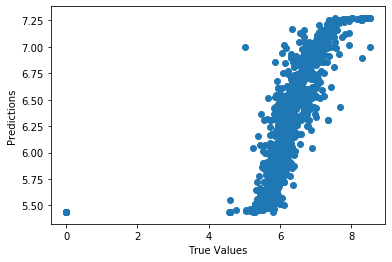

In [91]:
## The line / model
_=plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

> <font color=brown>Cross Validation</font>

In [95]:
MSEs = cross_val_score(lasso, X, y, scoring='neg_mean_squared_error', cv=4 )

In [96]:
mean_MSE = np.mean(MSEs)
print(mean_MSE)

-0.0866459503759819


In [97]:
MSEs

array([-0.09599909, -0.10835285, -0.10531908, -0.03691278])

In [103]:
new = (-0.09599909 * -0.10835285 * -0.10531908 * -0.03691278)